In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
varinfo.clear()

In [4]:
module = fc.eightb.preselection.t8btag_minmass_jet_eta28
dout = 't8btag_minmass_jet_eta28'

In [5]:
signal = ObjIter([ Tree(f) for f in module.signal_list ])
bkg = ObjIter([ Tree(module.QCD_B_List), Tree(module.TTJets)])

100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


In [6]:
bkg.reweight(2.3)
bkg.set_systematics(0.2)

[None, None]

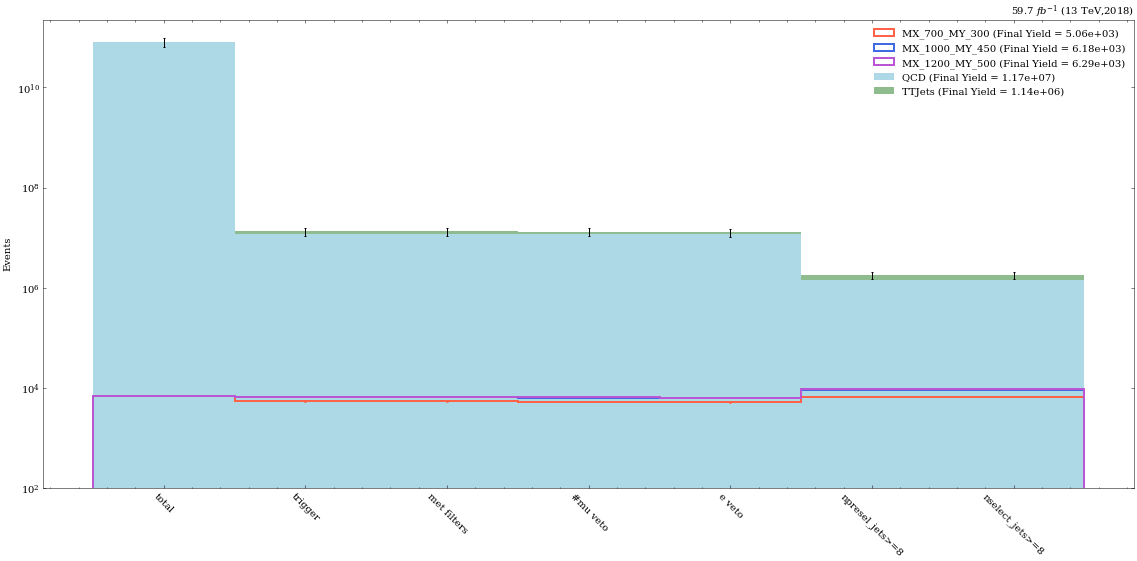

In [7]:
def get_efficiency(histo):
    print(histo)
    return 

study.cutflow(
    signal+bkg, legend=True, legend_loc="upper right",
    h_label_stat="Final Yield = {histo[4]:0.2e}",
    ylim=(1e2, -1), log=True,
    saveas="cutflow"
)

In [8]:
from collections import defaultdict
def get_sample_yields(t):
    lumi,_ = lumiMap[2018]
    class _sample:
        def __init__(self):
            self.yields = 0
            self.xsec = 0
    samples = defaultdict(_sample)
    for i, f in enumerate(t.filelist):
        mask = t.sample_id==i
        yields = ak.sum(t.scale[mask])*lumi

        samples[f.sample].yields += yields
        samples[f.sample].xsec = f.xsec

    for name, sample in samples.items():
        print(f'{name}, {sample.xsec}, {sample.yields}')
(signal+bkg).apply(get_sample_yields)

NMSSM_XYY_YToHH_8b, 0.11504969328885763, 3222.208982128364
NMSSM_XYY_YToHH_8b, 0.11504969328885763, 4431.215764906873
NMSSM_XYY_YToHH_8b, 0.11504969328885763, 4779.8079689321185
QCD_bEnriched_HT100to200, 1127000.0, 12862.077334571042
QCD_bEnriched_HT200to300, 80430.0, 30527.990938666848
QCD_bEnriched_HT300to500, 16620.0, 406240.97562700714
QCD_bEnriched_HT500to700, 1487.0, 354017.4611018744
QCD_bEnriched_HT700to1000, 296.5, 181986.7478962023
QCD_bEnriched_HT1000to1500, 46.61, 56866.583474465915
QCD_bEnriched_HT1500to2000, 3.72, 6936.066215835904
QCD_bEnriched_HT2000toInf, 0.6462, 1328.4353837001058
QCD_HT200to300_BGenFilter, 111700.0, 37053.91327145901
QCD_HT300to500_BGenFilter, 27960.0, 684037.058063545
QCD_HT500to700_BGenFilter, 3078.0, 750677.3275423431
QCD_HT700to1000_BGenFilter, 721.8, 483086.17691453925
QCD_HT1000to1500_BGenFilter, 138.2, 189304.73342654022
QCD_HT1500to2000_BGenFilter, 13.61, 28993.701062142674
QCD_HT2000toInf_BGenFilter, 2.92, 6838.8848027272725
TTJets, 831.76, 

[None, None, None, None, None]

100%|██████████| 1/1 [00:05<00:00,  5.85s/it]


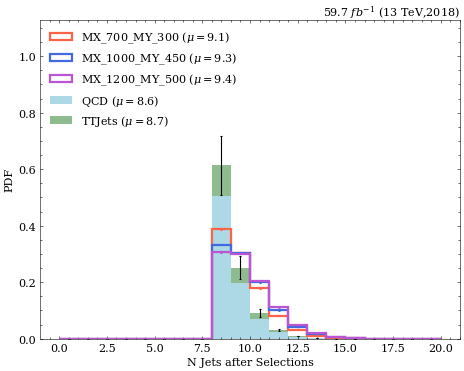

In [9]:
study.quick(
    signal+bkg, legend=True, h_label_stat='mean',
    efficiency=True,
    varlist=['n_jet'],
    xlabels=['N Jets after Selections'],
    saveas=f'{dout}/n_presel_jets'
)

100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


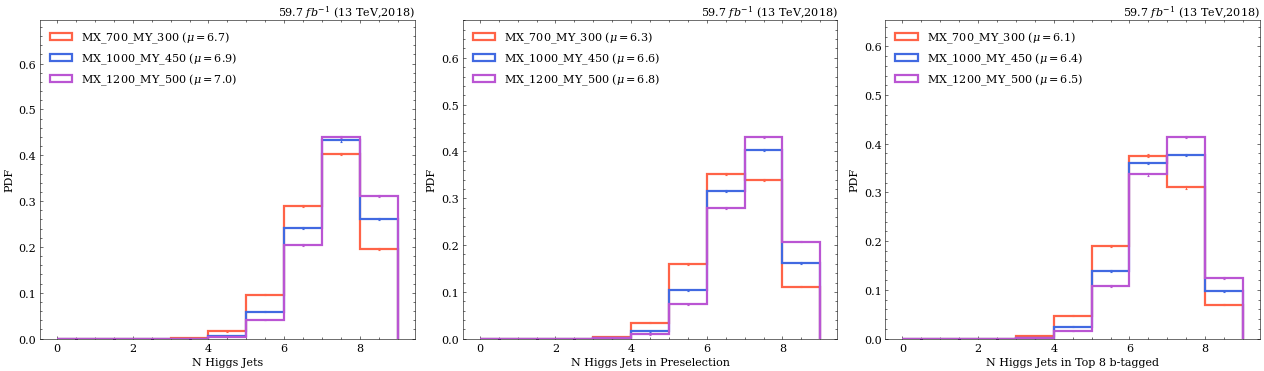

In [10]:
study.quick(
    signal, legend=True, h_label_stat='mean',
    efficiency=True,
    varlist=['nfound_all','nfound_presel','nfound_select'],
    xlabels=['N Higgs Jets','N Higgs Jets in Preselection','N Higgs Jets in Top 8 b-tagged'],
    dim=-1,
    saveas=f'{dout}/n_higgs_jets'
)

In [11]:
njets_lost = lambda t:t.nfound_presel-t.nfound_select

def frac_events(t):
    nlost = njets_lost(t)
    return f"{ak.mean(nlost>0):0.2%}"

signal.apply(frac_events)

['16.03%', '19.39%', '21.24%']

100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


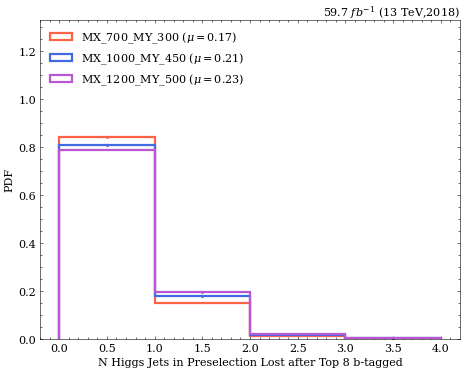

In [12]:
study.quick(
    signal, legend=True, h_label_stat='mean',
    varlist=[njets_lost],
    xlabels=['N Higgs Jets in Preselection Lost after Top 8 b-tagged'],
    dim=-1,
    efficiency=True,
    saveas=f'{dout}/n_higgs_jets_lost'
)

100%|██████████| 3/3 [00:07<00:00,  2.61s/it]


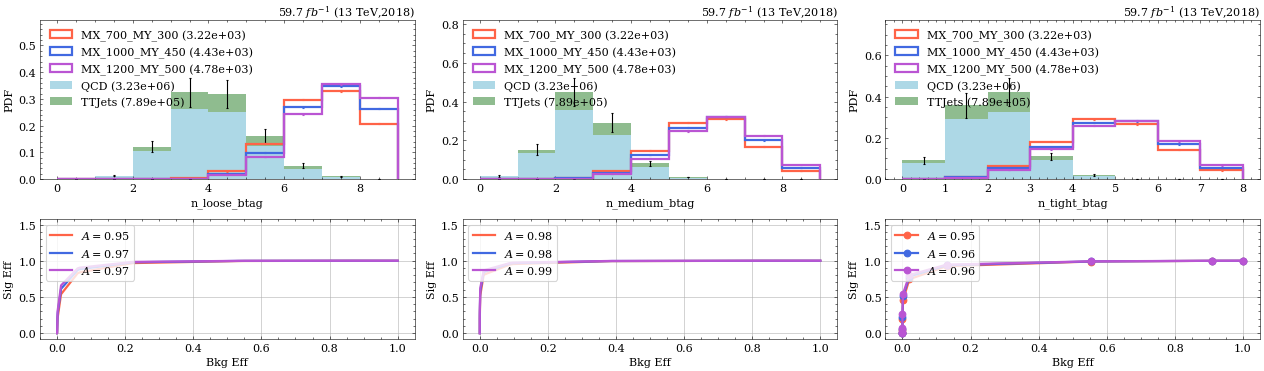

In [13]:
study.quick(
    bkg+signal, legend=True,
    varlist=['n_loose_btag','n_medium_btag','n_tight_btag'],
    efficiency=True, dim=-1,
    **study.auroc,

    saveas=f'{dout}/btag_multi'
)

In [14]:
(signal+bkg).apply(lambda t : build_collection(t, 'H\dY\d_b\d', 'jet', ordered='ptRegressed'))
(signal+bkg).apply(lambda t : build_collection(t, 'H\dY\d', 'higgs', ordered='pt'))

[None, None, None, None, None]

100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


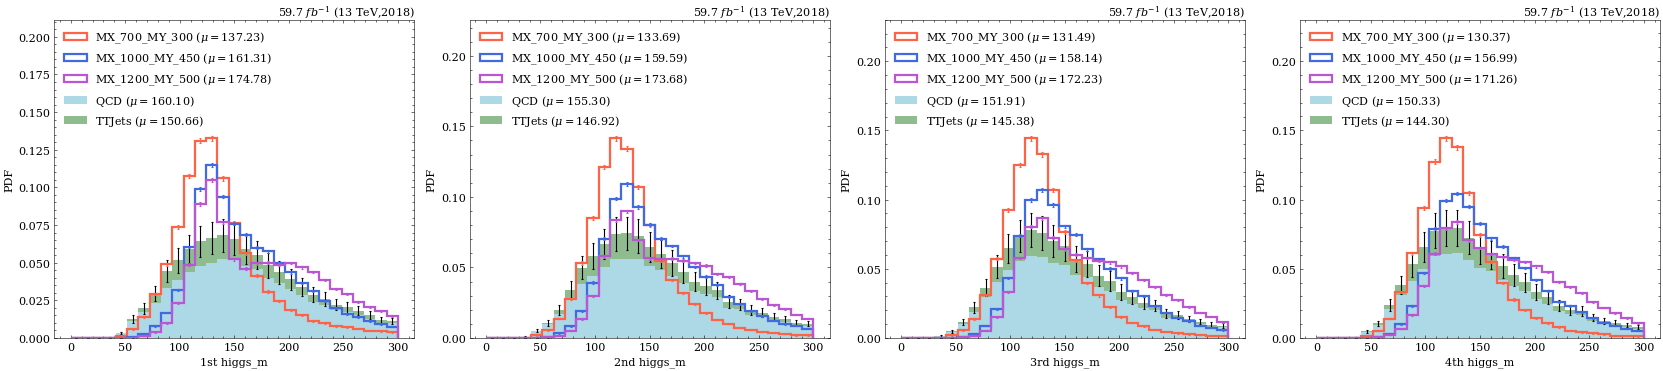

In [15]:
study.quick(
    signal+bkg,
    legend=True, h_label_stat='$\mu={stats.mean:0.2f}$',
    varlist=[f'higgs_m[:,{i}]' for i in range(4)],
    binlist=[(0,300,30)]*4,
    dim=-1,
    efficiency=True,
    saveas=f'{dout}/higgs_m'
)

In [16]:
signal.apply(lambda t : build_collection(t, 'gen_H\dY\d', 'gen_higgs', ordered='pt'))

[None, None, None]

In [17]:
varinfo.jet_btag = dict(bins=(0,1,30))

100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


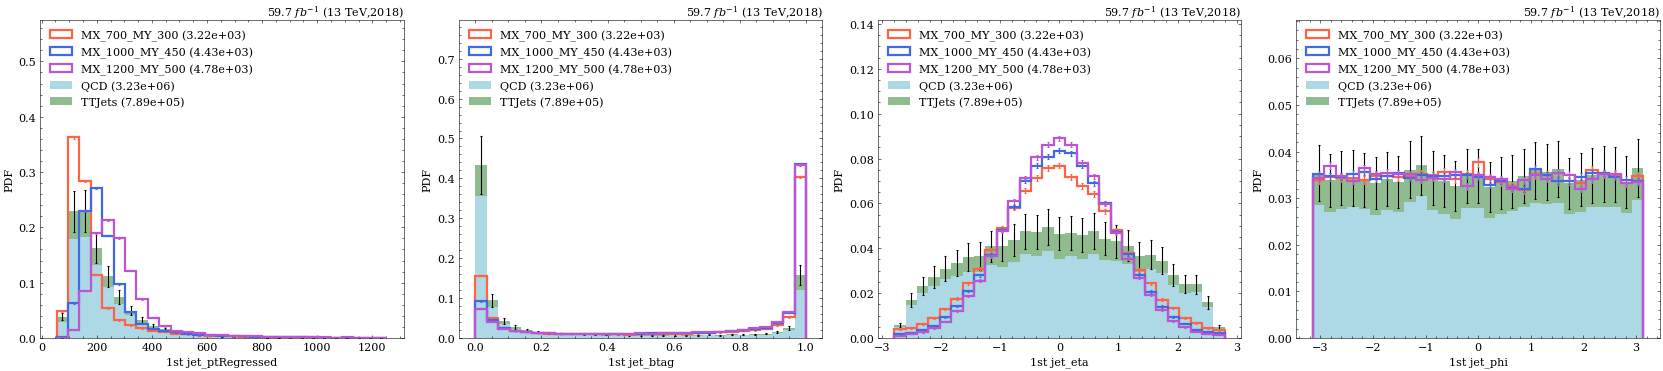

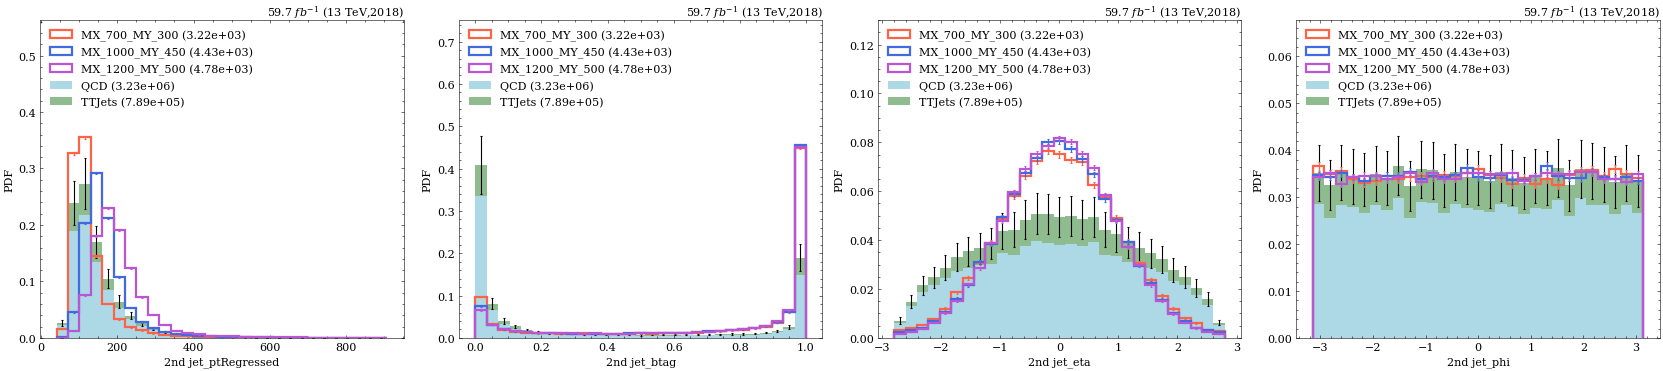

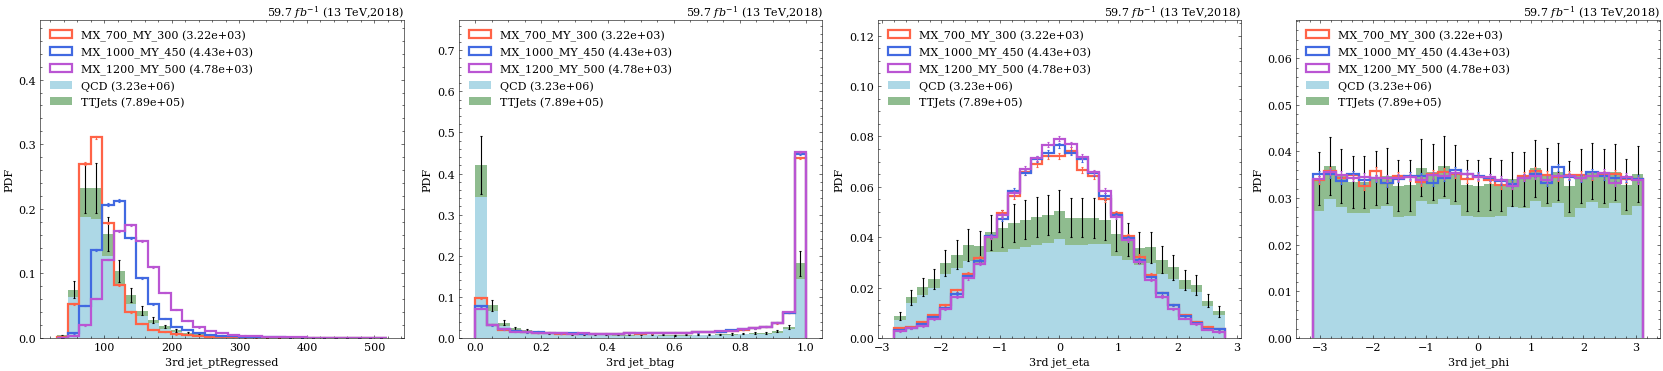

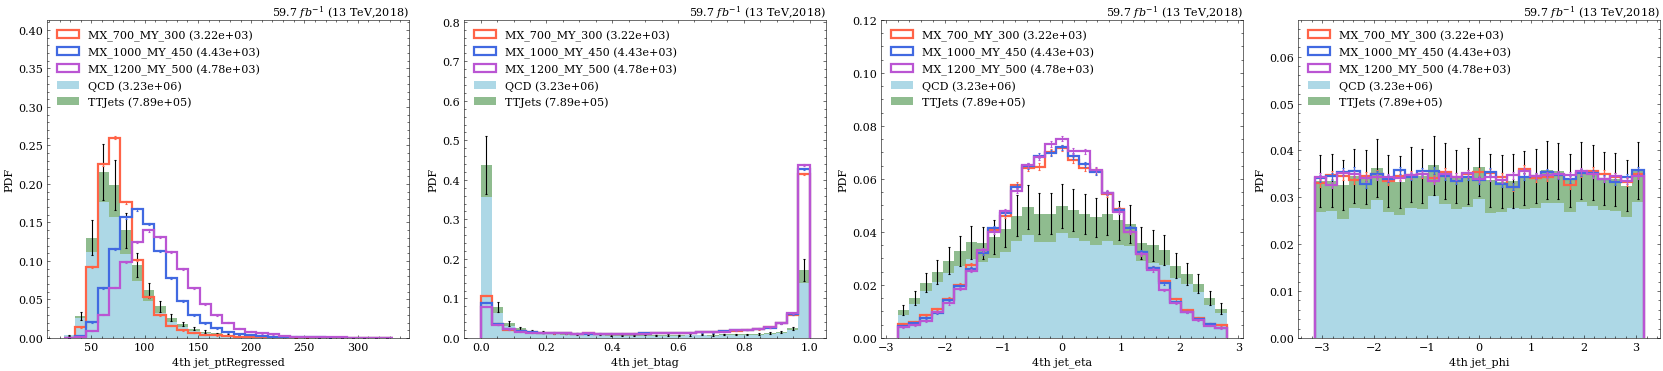

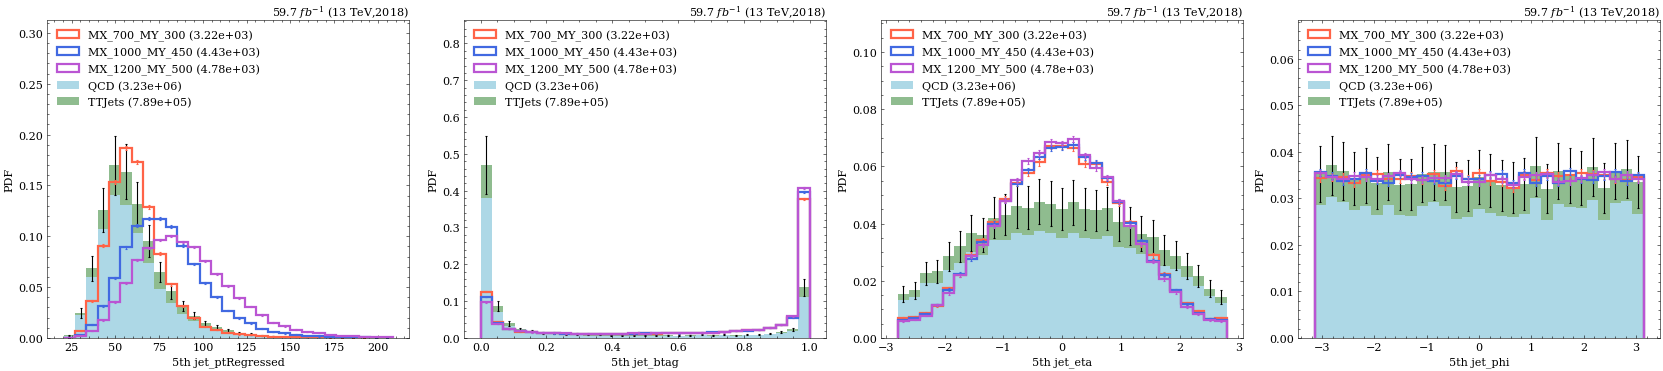

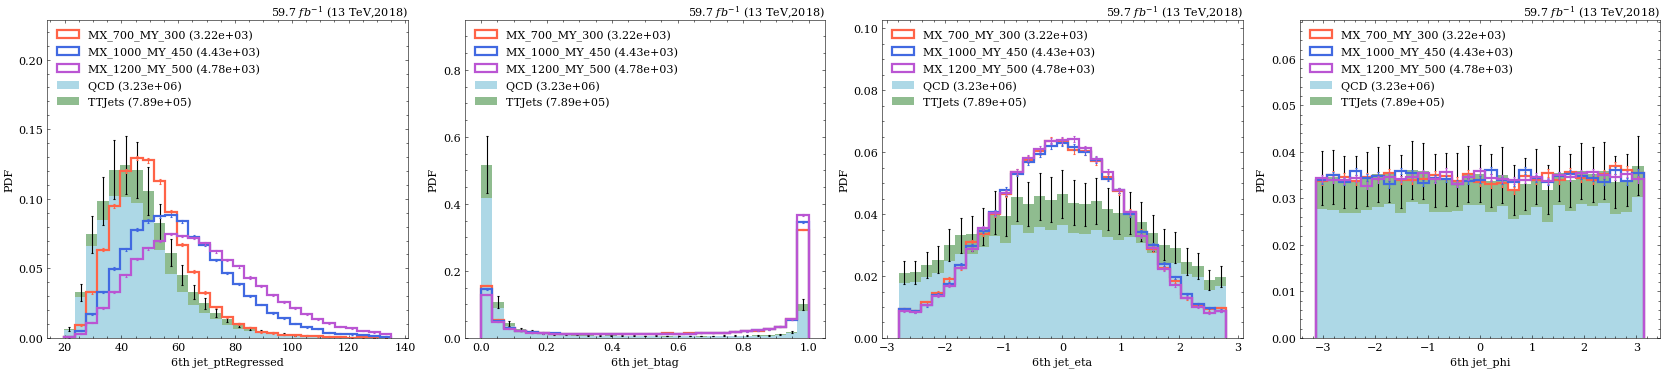

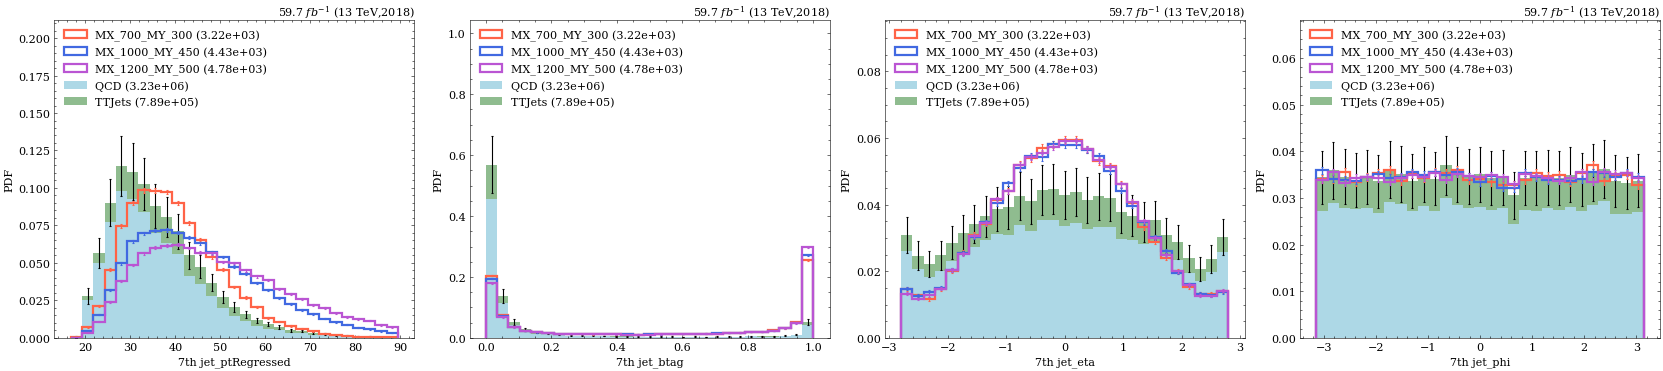

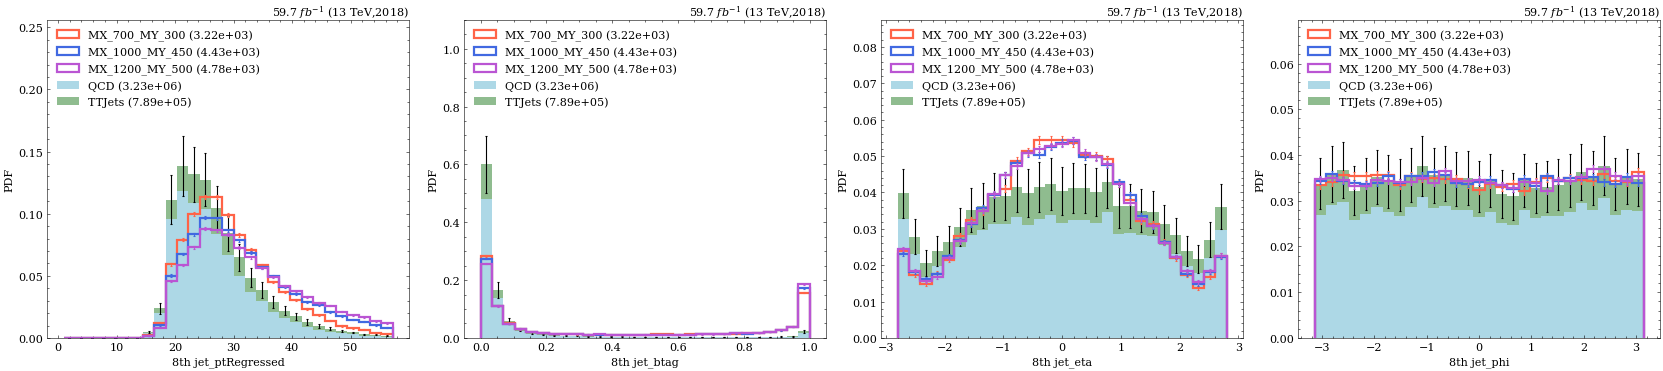

In [18]:
for i in range(8):
    study.quick( 
        signal+bkg, legend=True, 
        varlist=[f'jet_{var}[:,{i}]' for var in ('ptRegressed','btag','eta','phi')],
        efficiency=True,
        dim=-1,
        saveas=f'{dout}/{ordinal(i)}_pt_jet'
    )

In [19]:
varinfo.higgs_m = dict(bins=(0,500,30))

100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


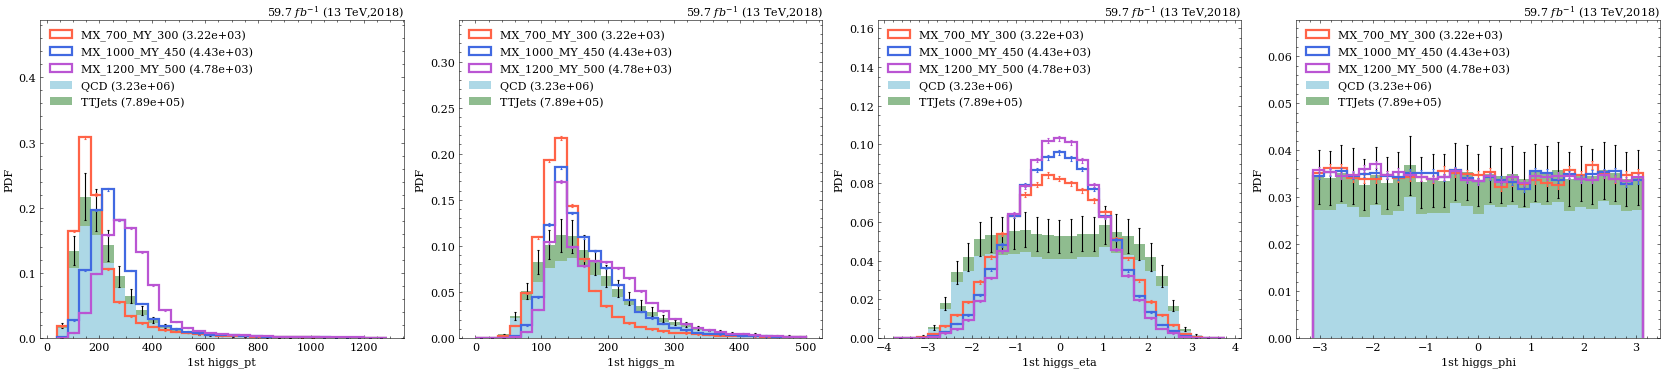

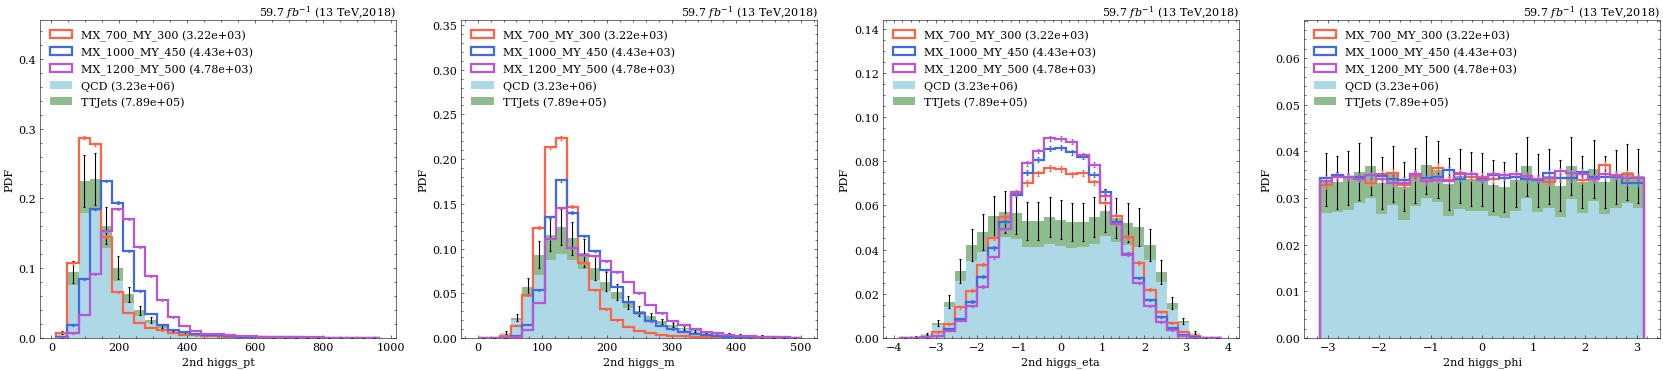

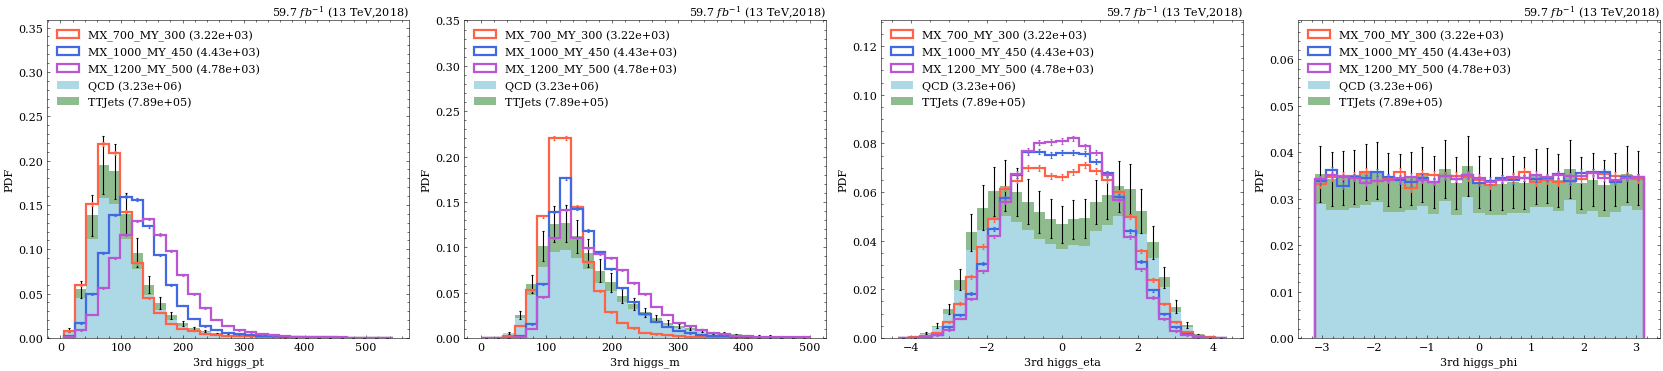

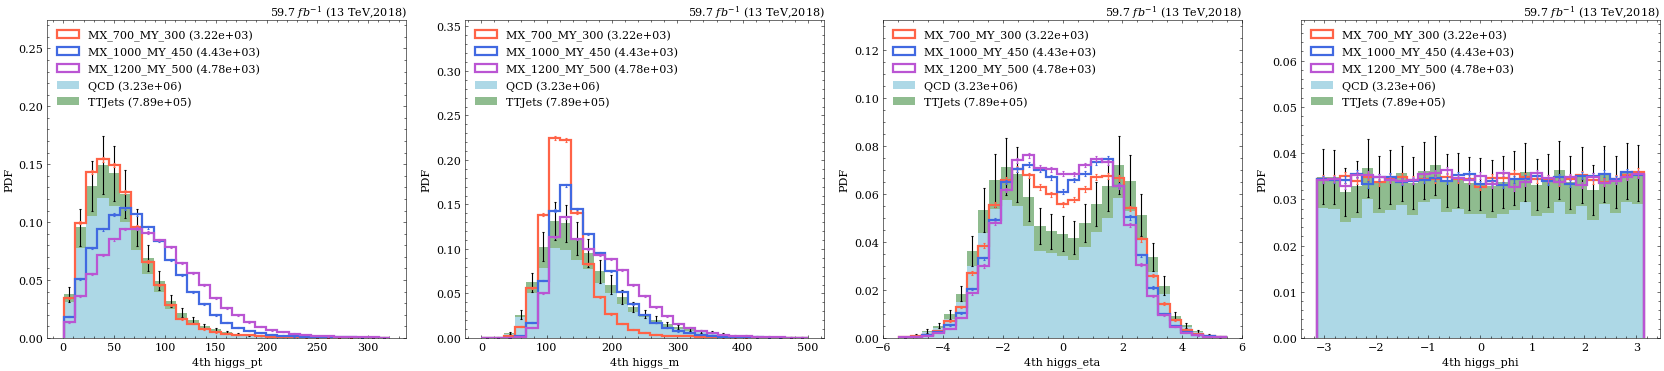

In [20]:
for i in range(4):
    study.quick( 
        signal+bkg, legend=True, efficiency=True,
        varlist=[f'higgs_{var}[:,{i}]' for var in ('pt','m','eta','phi')],
        dim=-1,
        saveas=f'{ordinal(i)}_pt_higgs'
    )

In [21]:
varinfo.Y1_m = dict(bins=(0,1000,30))
varinfo.Y2_m = dict(bins=(0,1000,30))


100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


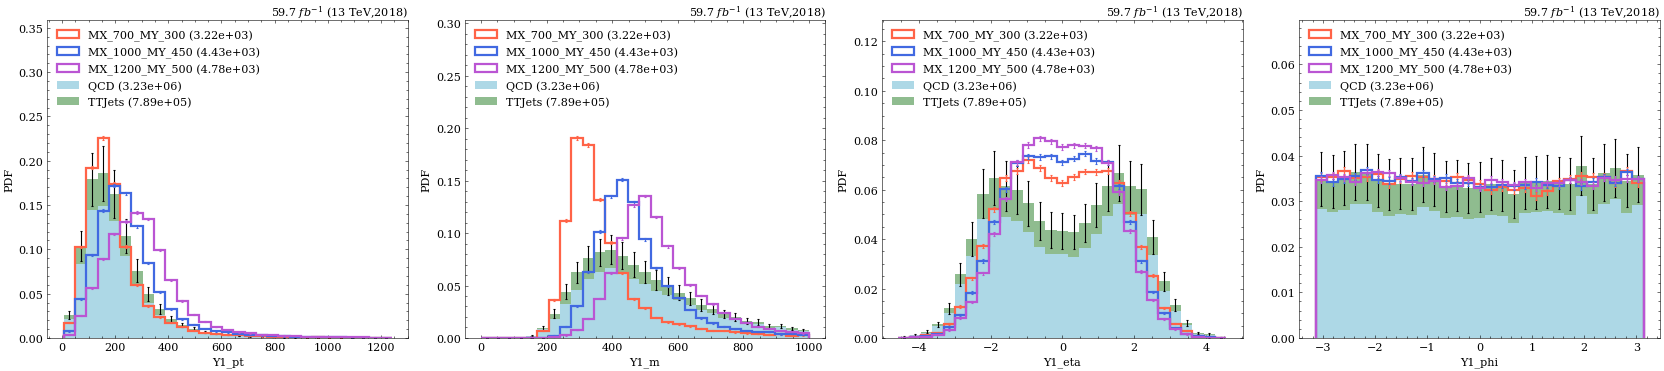

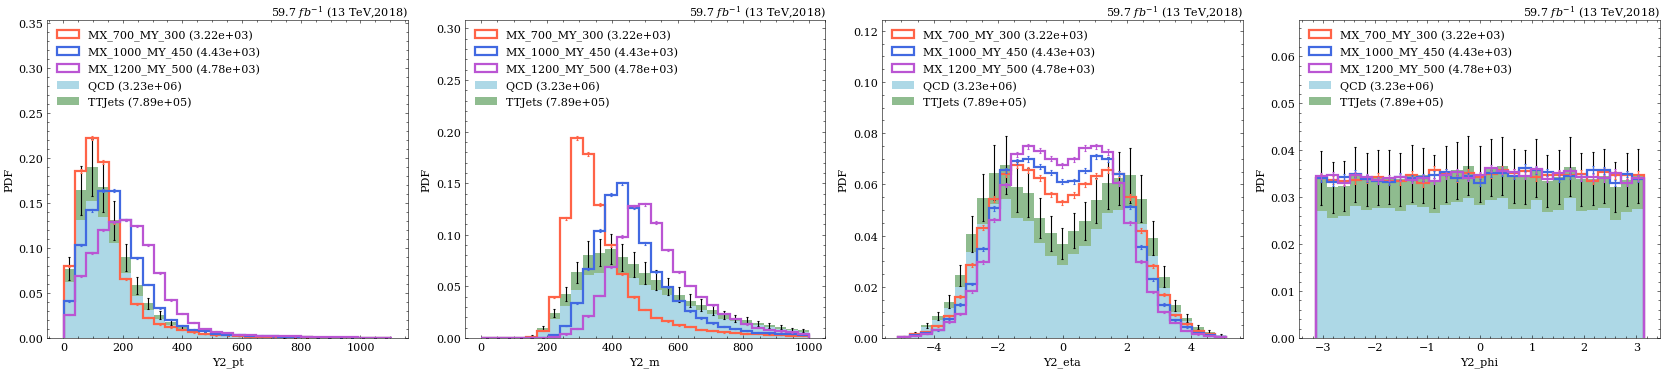

In [22]:
for i in range(2):
    study.quick( 
        signal+bkg, legend=True, efficiency=True,
        varlist=[f'Y{i+1}_{var}' for var in ('pt','m','eta','phi')],
        dim=-1,
        saveas=f'{dout}/{ordinal(i)}_pt_y'
    )

In [23]:
varinfo.X_m = dict(bins=(500,2000,30))

100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


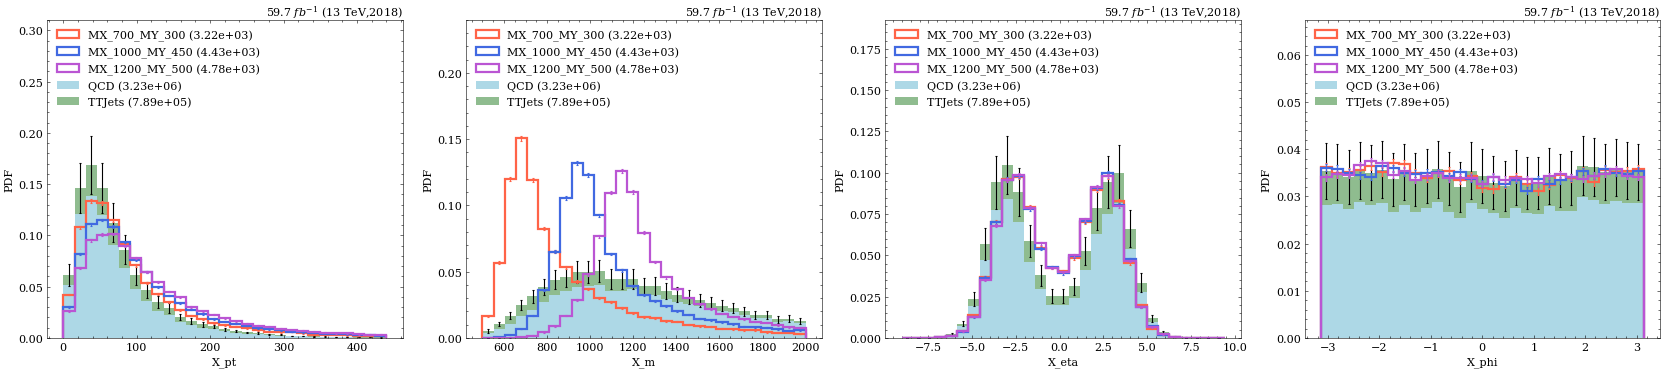

In [24]:
study.quick( 
    signal+bkg, legend=True, efficiency=True,
    varlist=[f'X_{var}' for var in ('pt','m','eta','phi')],
    dim=-1,
    saveas=f'{dout}/X'
)

100%|██████████| 1/1 [00:04<00:00,  4.68s/it]


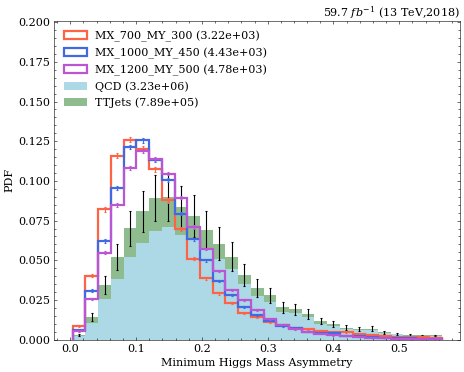

In [25]:
def hm_asym(t):
    hm = np.abs(t.higgs_m)
    hm_max, hm_min = ak.max(hm, axis=-1), ak.min(hm, axis=-1)
    asym = (hm_max-hm_min)/(hm_max+hm_min)
    t.extend(hm_asym=asym)
    return asym

study.quick(
    signal+bkg, 
    legend=True,
    # efficiency=True, 
    efficiency=True,
    varlist=[hm_asym],
    xlabels=['Minimum Higgs Mass Asymmetry'],
    saveas=f'{dout}/hm_asym',
)

100%|██████████| 1/1 [00:05<00:00,  5.13s/it]


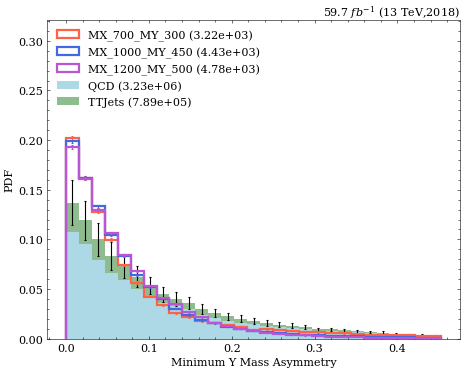

In [26]:
def ym_asym(t):
    ym = ak_stack([t.Y1_m, t.Y2_m])
    ym_max, ym_min = ak.max(ym, axis=-1), ak.min(ym, axis=-1)
    asym = (ym_max-ym_min)/(ym_max+ym_min)
    t.extend(ym_asym=asym)
    return asym

study.quick(
    signal+bkg, 
    legend=True,
    # efficiency=True, 
    efficiency=True,
    varlist=[ym_asym],
    xlabels=['Minimum Y Mass Asymmetry'],
    saveas=f'{dout}/ym_asym',
)

100%|██████████| 1/1 [00:28<00:00, 28.76s/it]


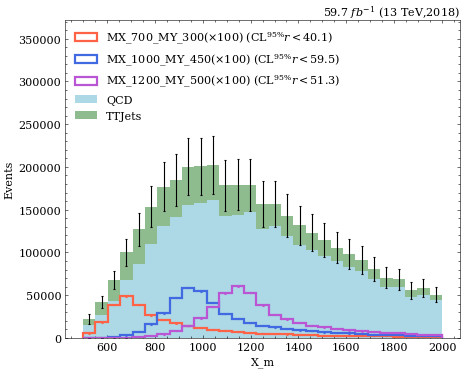

In [27]:
study.quick(
    signal+bkg, legend=True,
    # scale=[100]*len(signal),
    plot_scale=[100]*len(signal),
    varlist=['X_m'],
    limits=True,
    saveas=f'{dout}/limits/no_cuts'
)

100%|██████████| 1/1 [00:21<00:00, 21.25s/it]


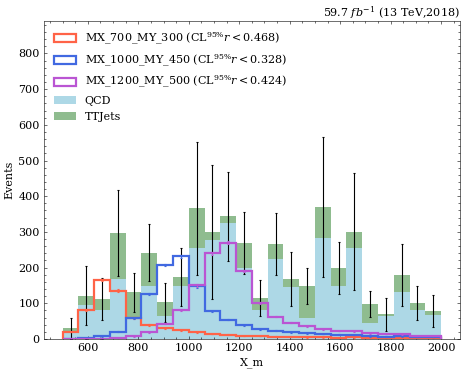

In [28]:
study.quick(
    signal+bkg, legend=True,
    masks=lambda t:t.n_loose_btag==8,
    varlist=['X_m'],
    binlist=[(500,2000,25)],
    limits=True,
    saveas=f'{dout}/limits/n_loose_btag==8'
)

100%|██████████| 1/1 [00:22<00:00, 22.75s/it]


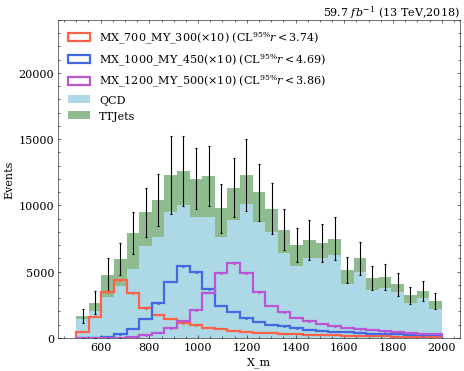

In [29]:
study.quick(
    signal+bkg, legend=True,
    masks=lambda t:t.n_loose_btag>=6,
    plot_scale=[10]*len(signal),
    varlist=['X_m'],
    limits=True,
    saveas=f'{dout}/limits/n_loose_btag>=6'
)

100%|██████████| 1/1 [00:22<00:00, 22.76s/it]


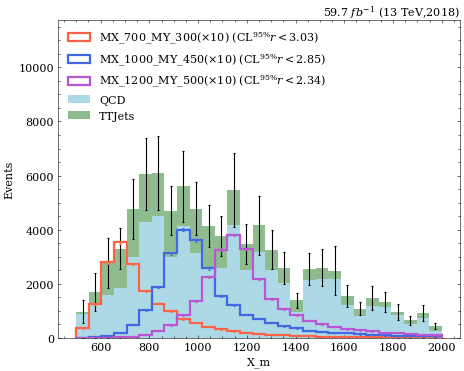

In [30]:
study.quick(
    signal+bkg, legend=True,
    plot_scale=[10]*len(signal),
    masks=lambda t:(t.n_loose_btag>=6)&(t.hm_asym<0.15),
    varlist=['X_m'],
    limits=True,
    saveas=f'{dout}/limits/n_loose_btag>=6&hm_asym<0.15'
)

100%|██████████| 1/1 [00:11<00:00, 11.14s/it]


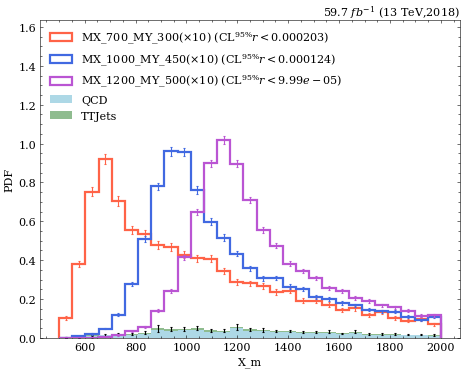

In [31]:
study.quick(
    signal+bkg, legend=True,
    plot_scale=[10]*len(signal),
    masks=lambda t:(t.n_loose_btag>=6)&(t.hm_asym>=0.15),
    varlist=['X_m'],
    limits=True,
    saveas=f'{dout}/limits/n_loose_btag>=6&hm_asym>=0.15'
)

In [32]:
def compare_masks(var, masks, label=None, figax=None, saveas=None, **kwargs):
    n = 4
    if figax is None:
      figax = study.get_figax(n, dim=(-1,n))
    fig, axs = figax

    h_linestyle = ["-","-."]
    
    for i, sample in enumerate(signal):
      study.quick(
        [sample,sample], legend=True,
        masks=masks,
        label=label,
        h_linestyle=h_linestyle,
        varlist=[var],
        text=(0.0,1.0, sample.sample),
        text_style=dict(ha='left',va='bottom'),
        figax=(fig,axs.flat[i]),
        **kwargs,
      )

    if not bkg: return

    study.quick_region(
      bkg, bkg, legend=True, 
      masks=masks,
      h_color=['grey']*3,
      label=label,
      h_linestyle=h_linestyle,
      varlist=[var],
      text=(0.0,1.0,'MC-Bkg'),
      text_style=dict(ha='left',va='bottom'),
      figax=(fig,axs.flat[-1]),
      **kwargs,
    )

    if saveas:
      study.save_fig(fig, saveas)

100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


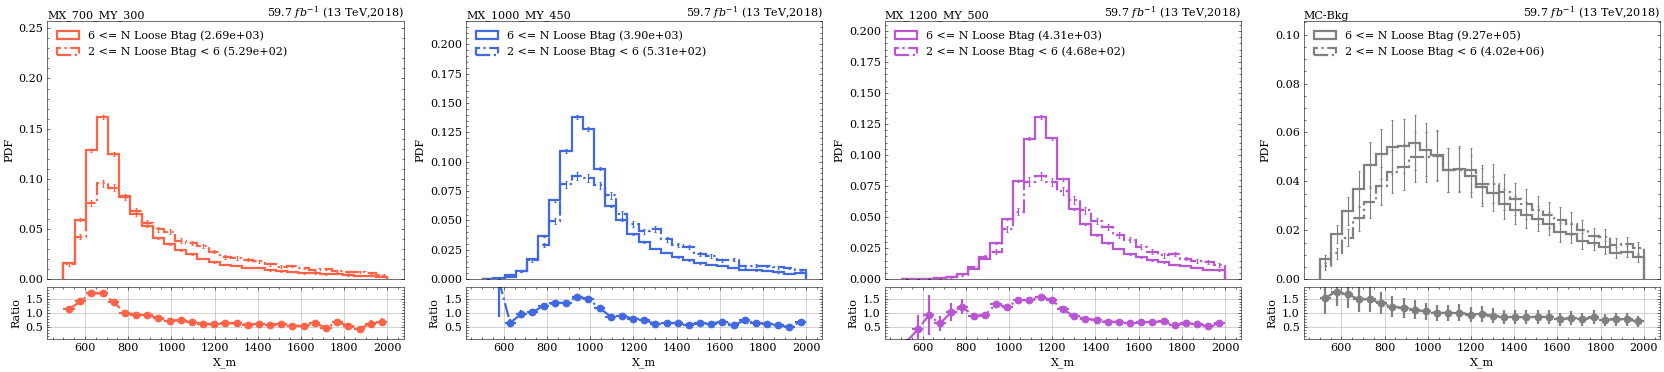

In [33]:
compare_masks(
    'X_m',
    masks=[lambda t:t.n_loose_btag>=6,lambda t:(t.n_loose_btag>=2)&(t.n_loose_btag<6)], 
    label=['6 <= N Loose Btag','2 <= N Loose Btag < 6'],
    efficiency=True,
    ratio=True,
    saveas=f'{dout}/X_m_vs_loose_btag'
    )


100%|██████████| 1/1 [00:23<00:00, 23.15s/it]


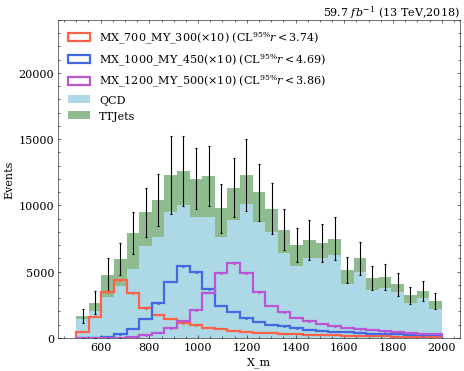

In [34]:
study.quick(
    signal+bkg, legend=True,
    plot_scale=[10]*len(signal),
    masks=lambda t:(t.n_loose_btag>=6),
    varlist=['X_m'],
    limits=True,
    saveas=f'{dout}/limits/6<=n_loose_btag'
)

100%|██████████| 1/1 [00:25<00:00, 25.50s/it]


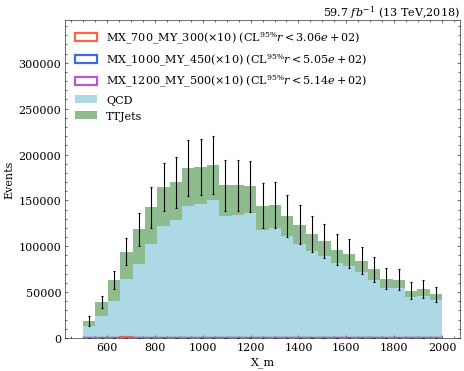

In [35]:
study.quick(
    signal+bkg, legend=True,
    plot_scale=[10]*len(signal),
    masks=lambda t:(t.n_loose_btag>=2)&(t.n_loose_btag<6),
    varlist=['X_m'],
    limits=True,
    saveas=f'{dout}/limits/2<=n_loose_btag<6'
)

100%|██████████| 1/1 [00:05<00:00,  5.52s/it]


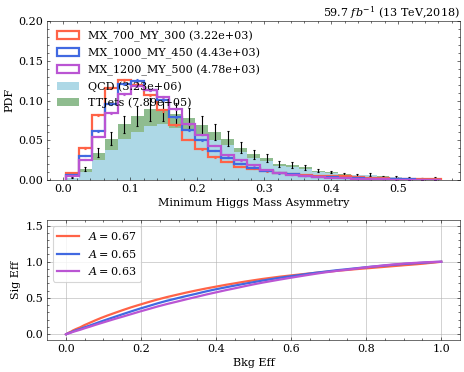

In [36]:
study.quick(
    signal+bkg, 
    legend=True,
    # efficiency=True, 
    efficiency=True,
    varlist=[hm_asym],
    xlabels=['Minimum Higgs Mass Asymmetry'],

    **study.auroc,
    saveas=f'{dout}/hm_asym_roc',
)

100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


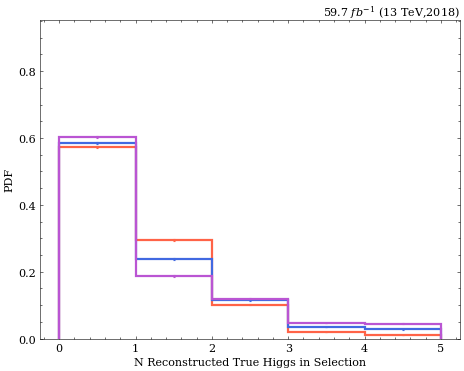

In [37]:
study.quick(
    signal,
    varlist=['nfound_paired_h'],
    efficiency=True,
    xlabels=['N Reconstructed True Higgs in Selection']
)

100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


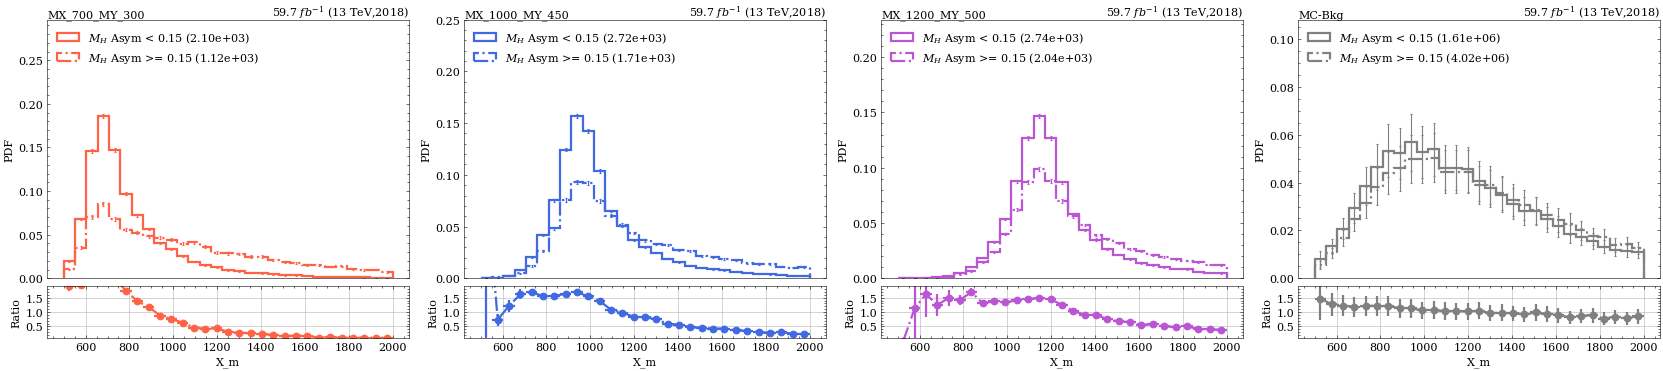

In [38]:
compare_masks(
    'X_m',
    masks=[lambda t:t.hm_asym < 0.15,lambda t:t.hm_asym >= 0.15], 
    label=['$M_{H}$ Asym < 0.15','$M_{H}$ Asym >= 0.15'],
    efficiency=True,
    ratio=True,
    saveas=f'{dout}/X_m_vs_hm_asym'
    )


100%|██████████| 1/1 [00:24<00:00, 24.46s/it]


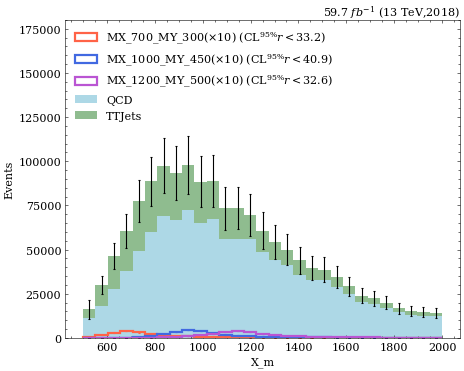

In [39]:
study.quick(
    signal+bkg, legend=True,
    plot_scale=[10]*len(signal),
    masks=lambda t:t.hm_asym<0.15,
    varlist=['X_m'],
    limits=True,
    saveas=f'{dout}/limits/hm_asym<0.15'
)

100%|██████████| 1/1 [00:24<00:00, 24.54s/it]


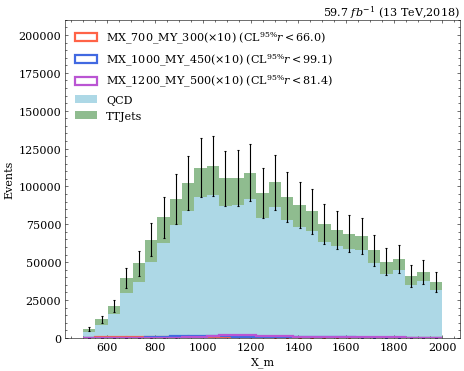

In [40]:
study.quick(
    signal+bkg, legend=True,
    plot_scale=[10]*len(signal),
    masks=lambda t:t.hm_asym>=0.15,
    varlist=['X_m'],
    limits=True,
    saveas=f'{dout}/limits/hm_asym>=0.15'
)

100%|██████████| 1/1 [00:07<00:00,  7.24s/it]


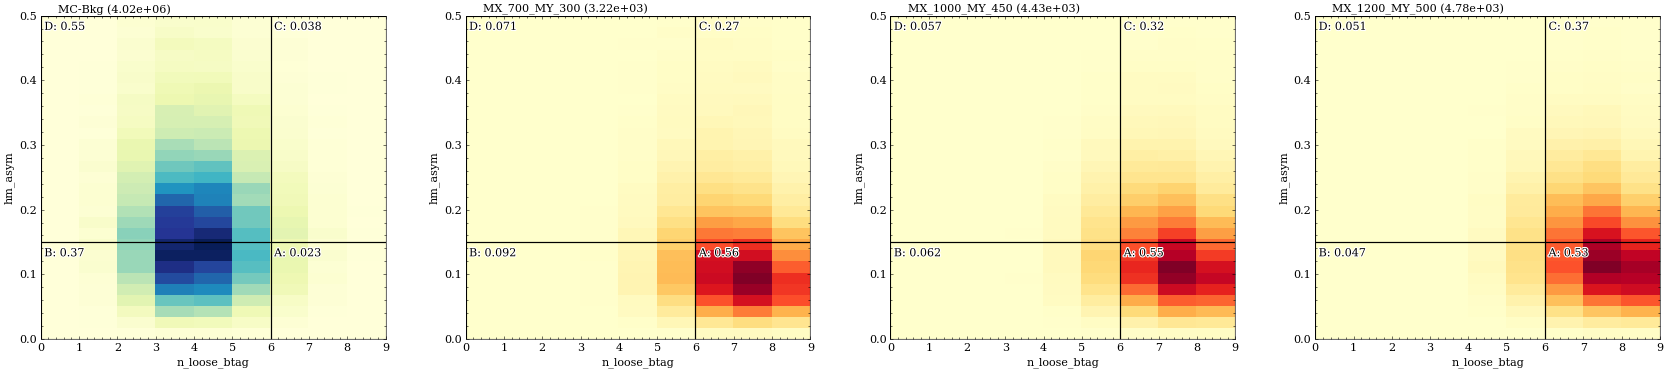

In [41]:
study.quick2d(
    signal+bkg,
    varlist=['n_loose_btag','hm_asym'],
    binlist=[None, (0,0.5,30)],
    exe=draw_abcd(x_r=(0,6,9),y_r=(0,0.15,0.5), regions=["C","D","A","B"]),
    saveas=f'{dout}/limits/abcd_loose_btag_vs_hm_asym'
)

In [42]:
bdt = ABCD(
    features=['X_m','X_pt'],
    a = lambda t : (t.n_loose_btag >= 6) &                        (t.hm_asym < 0.15),
    b = lambda t : (t.n_loose_btag >= 2) & (t.n_loose_btag < 6) & (t.hm_asym < 0.15),
    c = lambda t : (t.n_loose_btag >= 6) &                        (t.hm_asym > 0.15),
    d = lambda t : (t.n_loose_btag >= 2) & (t.n_loose_btag < 6) & (t.hm_asym > 0.15),
)

100%|██████████| 1/1 [00:24<00:00, 24.18s/it]


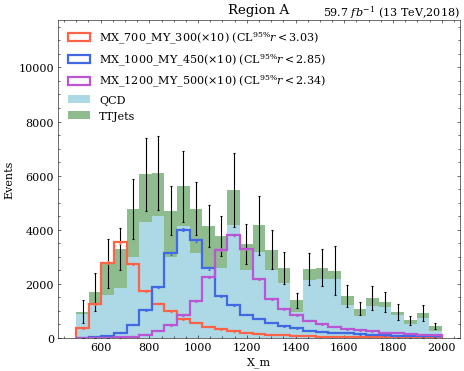

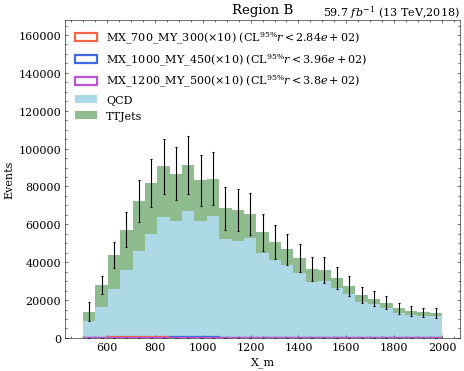

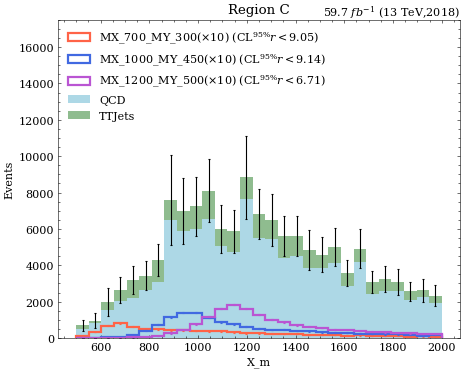

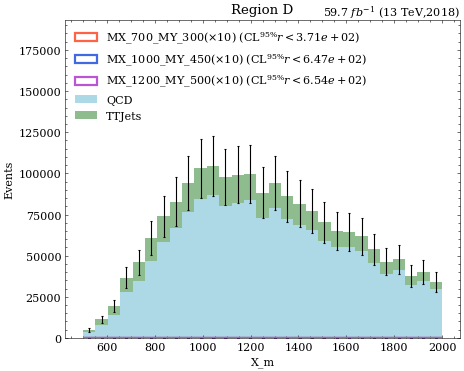

In [43]:
for r in ('a','b','c','d'):
    study.quick(
        signal + bkg, 
        legend=True,
        plot_scale=[10]*len(signal),
        masks=getattr(bdt,r),
        varlist=['X_m'],
        limits=True,
        title=f'Region {r.upper()}',
        saveas=f'{dout}/limits/region_{r}'
    )

In [44]:
bdt.train(bkg)
bdt.print_results(bkg)

--- ABCD Results ---
k = 6.942e-02
k*(b/a)-1  = 10.69%
BDT(b)/a-1 = 6.00%



100%|██████████| 2/2 [00:07<00:00,  3.75s/it]


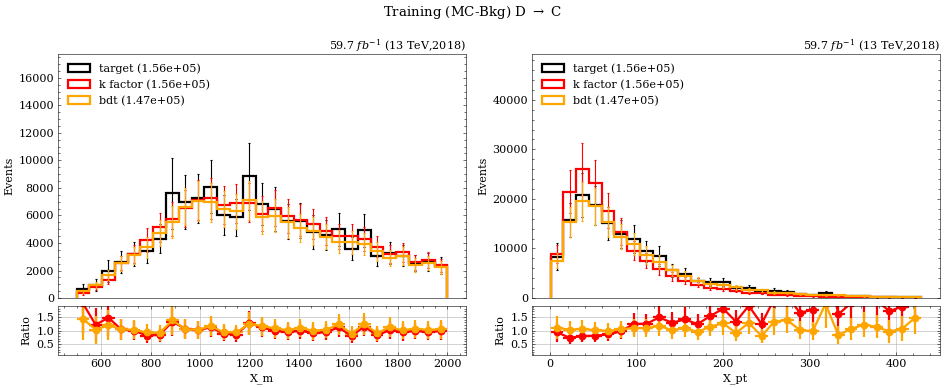

In [45]:
study.quick_region(
    bkg, bkg, bkg, label=['target','k factor','bdt'],
    h_color=['black','red','orange'], legend=True,
    masks=[bdt.c]*len(bkg)+[bdt.d]*(len(bkg)*2),
    scale=[1]*len(bkg)+[bdt.scale_tree]*len(bkg)+[bdt.reweight_tree]*len(bkg),
    varlist=bdt.feature_names,
    suptitle='Training (MC-Bkg) D $\\rightarrow$ C',
    ratio=True,
    saveas=f'{dout}/bdt/training'
)

100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


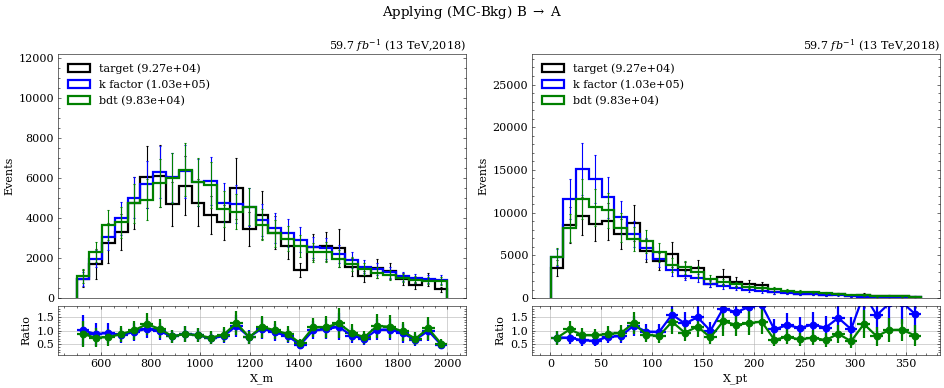

In [46]:
study.quick_region(
    bkg, bkg, bkg, label=['target','k factor','bdt'],
    h_color=['black','blue','green'], legend=True,
    masks=[bdt.a]*len(bkg)+[bdt.b]*(len(bkg)*2),
    scale=[1]*len(bkg)+[bdt.scale_tree]*len(bkg)+[bdt.reweight_tree]*len(bkg),
    varlist=bdt.feature_names,
    suptitle='Applying (MC-Bkg) B $\\rightarrow$ A',
    saveas=f'{dout}/bdt/applying',
    ratio=True,
)

100%|██████████| 1/1 [00:22<00:00, 22.56s/it]


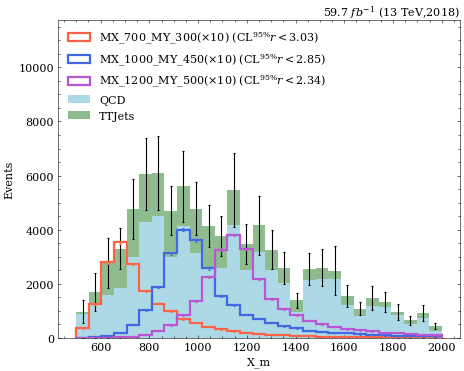

In [47]:
study.quick(
    signal + bkg, 
    legend=True,
    plot_scale=[10]*len(signal),
    masks=bdt.a,
    varlist=['X_m'],
    limits=True,
    saveas=f'{dout}/limits/region_a'
)

100%|██████████| 1/1 [00:22<00:00, 22.81s/it]


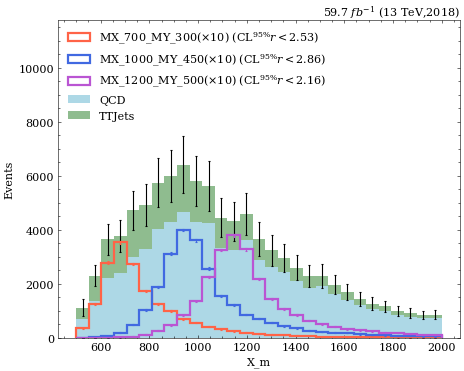

In [48]:
study.quick(
    signal + bkg, 
    legend=True,
    plot_scale=[10]*len(signal),
    masks=[bdt.a]*len(signal)+[bdt.b]*(len(bkg)*2),
    scale=[1]*len(signal)+[bdt.reweight_tree]*len(bkg),
    varlist=['X_m'],
    limits=True,
    saveas=f'{dout}/limits/bdt_bkg_model'
)